# 0. Setup

In [3]:
# | output: false
# | echo: false
import os
from dotenv import load_dotenv

load_dotenv()

# IMPORT LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

# IMPORT EMBEDDING MODEL
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

# IMPORT VECTOR STORE
from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embeddings)

# 1. Indexing

## Loading

In [4]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader

# Load and chunk contents of the blog
# DocumentLoaders are objects that load in data from a source and return a list of Document objects.
# WebBaseLoader uses urllib to load HTML from web URLs and BeautifulSoup to parse it to text
# customize the HTML -> text parsing using "bs_kwargs", passing a bs4.SoupStrainer
# https://beautiful-soup-4.readthedocs.io/en/latest/index.html?highlight=soupstrainer#soupstrainer
bs4_strainer = bs4.SoupStrainer(
    class_=("post-content", "post-title", "post-header")
)
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={
        "parse_only": bs4_strainer,
    },
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")
print(docs[0].page_content[:500])

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43047


      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


## Splitting

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# RecursiveCharacterTextSplitter recursively splits the document using common separators like new lines until each chunk is the appropriate size.
# TextSplitter is a subclass of DocumentTransformers. It splits a list of Documents into smaller chunks.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog posts into {len(all_splits)} sub-documents")

Split blog posts into 63 sub-documents


## Storing

In [6]:
# Index chunks
document_ids = vector_store.add_documents(documents=all_splits) # won't use this variable, but getting it here for validaation
print(document_ids[:3])

['17befece-2dd1-4b7b-8453-5880e8b9e0ec', '06b3f4f0-59d1-46bd-acad-5d86ddeaca01', 'dd6a2833-4acd-4699-82d3-ce04ce37a69a']


# 2. Retrieval and Generation {#orchestration}

In [7]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


## Build LangGraph

To use LangGraph, we need to define three things:

The state of our application;
The nodes of our application (i.e., application steps);
The "control flow" of our application (e.g., the ordering of the steps).

**State**

In [8]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# Define state for application
# The state of our application controls what data is input to the application, transferred between steps, and output by the application.
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

**Nodes**

In [9]:
# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

**Edges**

In [10]:
from langgraph.graph import START, StateGraph

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

# 3. Usage

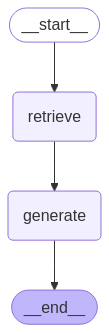

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Sync

In [12]:
result = graph.invoke({"question": "What is Task Decomposition?"})
# For ASYNC => await graph.ainvoke

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='dd6a2833-4acd-4699-82d3-ce04ce37a69a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth

### Streaming (Steps)

In [13]:
for step in graph.stream({"question": "What is Task Decomposition?"}, stream_mode="updates"):
    print(f"{step}\n\n----------------\n")
# For ASYNC => async for step in graph.astream

{'retrieve': {'context': [Document(id='dd6a2833-4acd-4699-82d3-ce04ce37a69a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can

### Streaming (Tokens)

In [14]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| De|composition| is| the| process| of| breaking| down| a| complex| task| into| smaller|,| manageable| steps|.| This| can| be| achieved| through| techniques| like| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts|,| which| allow| models| to| think| step| by| step| or| explore| multiple| reasoning| possibilities|.| Additionally|,| it| can| involve| simple| prompting|,| task|-specific| instructions|,| or| leveraging| external| planning| tools| like| P|DDL| for| long|-h|orizon| tasks|.||

# 4. Improved

* Ref: https://python.langchain.com/docs/tutorials/rag/#query-analysis
* Customize prompt
* Add metadata to a document and use it to filter a search
* Use a query analysis to take any (unstructured) user input

## Custom prompt

In [15]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

## Add metadata

In [16]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

## Prefix "query analysis"

In [18]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

from typing import Literal
from typing_extensions import Annotated

# TypedDict is a type that describes a dictionary.
# This one will be used to define the structure of the query in the app state
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [19]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    # langchain method that guarantees the a structured output!
    # LangChain typically implements this by:
    # (1) Adding instructions to the prompt telling the LLM to respond in a specific format (usually JSON)
    # (2) Parsing the response to extract the structured data
    # (3) Validating that the response matches the expected schema
    # (4) Retrying if the format is invalid (with some models)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

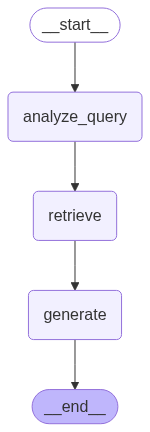

In [20]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='0da5c43f-264b-4c56-83dc-1d3713013f29', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39137, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adj